### __A/B Testing__

An A/B test is an experiment with two groups to establish which of the two is superior. If a standard (or no) treatment is used, it as called the *control*. A typical hypothesis is that a new treatment is better than the control.

__*Treatment*__ <br>
Something (drug, price, web headline) to which a subject is exposed.

__*Treatment group*__ <br>
A group of subjects exposed to a specific treatment.

__*Control group*__ <br>
A group of subject exposed to standard (or no) treatment.

__*Randomization*__ <br>
The process of randomly assigning subjects to treatments.

__*Subjects*__ <br>
The items (web visitors, patients, etc) that are exposed to treatments.

__*Test statistic*__ <br>
The metric used to measure the effect of the treatment.

Data scientists are less interested in the question:<br>
*Is the difference between price A and prive B statistically significant?* <br>
than in the question:<br>
*Which, out of multiple possible prices, is best?*

### __Hypothesis Tests__


__*Null hypothesis*__ <br>
The hypothesis that chance is to blame.

__*Alternative hyppothesis*__ <br>
Counterpoint to the null (what you hope to prove).

__*One-way test*__ <br>
Hypothesis test that counts chance results only in one direction.

__*Two-way test*__ <br>
Hypothesis test that counts chance results in two directions.

an A/B test is typically constructed with a hypothesis in mind (may be that price B produces higher profit). Forming hypothesis is a way to protect from being fooled by random chance. In a properly designed A/B test, you collect data on treatments A and B in a way that any observed difference between A and B must be due to either:
* Random chance in assignment of subjects
* A true difference between A and B

The goal then is to prove *null hypothesios* wrong, and hence, reject it. Show that the outcomes for groups A and B are more different than what chance might produce.

In wanting to prove that B is better than A, you want a *directional* alternative hypothesis. In this case, it's a *one-way* (or one tail) hypothesis test. This means that extreme chance results in only one direction count toward the p-value.

One-tail versus two-tail is not that relevant for data science, where the precision of p-value calculations is not terribly important.

### __Resampling__

Resampling in statistics means to repeatedly sample values from observed data. The goal is to assess random variability in a statsitc. It can also be used to assess and improve the accuracy of some machine-learning models (e.g. the predictions, form decision tree models built on multiple bootstrapped data sets can be averaged in a process known as bagging).

Two main types of resampling procedures:
* The bootstrap (ref. chapter 2)
* Permutation tests

Permutation tests are used to test hypotheses, typically involving two or more groups

__*Permutation test*__ <br>
The procedure of combining two or more samples together and randomly (or exhaustively) reallocating the observations to resamples. *Synonyms:* Randomization test, random permutation test, exact test.

__*Resampling*__ <br>
Drawing additional samples ("resamples") from an observed data set.

__*With or withour replacement*__ <br>
Whether or not an item is returned to the sample before the next draw (in sampling).



The permutation procedure is as follows:
<ol>
<li>Combine the results from the different groups into a single data set.</li>
<li>Shuffle the combined data and then randomly draw (without replacement) a resample of the same size as group A.</li>
<li>From the remaining data, randomly draw (without replacement) a resample of the same size as group B.</li>
<li>Do the same for groups C, D, etc.</li>
<li>Whatever statistic or estimate was calculated for the original samples, calculate it now for the resamples, and record. This yields one permutation iteration.</li>
<li>Repeat the previous steps $R$ times to yield a permutation distribution of the test statistic.</li>
</ol>

If the observed difference lies well within the test set of permuted differences then we have not proven anything. The observed difference is within the range of what chanve might porduce. If the observed difference lies outside of the permutation distribution, then chance is __not__ responsible. In other words, the difference is *statistically significant*.

There are two types of permutation tests:
* An exhaustive permutation test
* A bootstrap permutation test

We figure out all the possible ways the data could be divided. Only practical for small sample sizes.

in a bootstrap permutation test, the draws in steps 2 and 3 of the random permutation test are made *with replacement* instead of without. 

Both procedures are encountered in statistics, the distinction between then is not of consequence in the practice of data science.

### __Statistical Significance and p-Values__

__*p-value*__ <br>
Given a chance model that embodies the null hypothesis, the p-value is the probability of obtaining results as unusual or extreme as the observed results.

__*Alpha*__ <br>
The probability threshold of "unusualness" that chance results must surpass for actual outcomes to be deemed statistically significant.

__*Type 1 error*__ <br>
Mistakenly concluding an effect is real (when, in fact, it is due to chance.).

__*Type 2 error*__ <br>
Mistakenly concluding an effect is due to chance (when it is real).

It is not pratical to measure statistical significance from only looking at a graph, so the p-value is of interest. The frequency that the chance model produces a result more extreme than the obeserved result. We can estimate a p-value from the permutation test by taking the proportion of times the permutation test produces a difference equal to or greater than the observed difference.

Note that if you have a binomial distribution you can use the normal approximation for the p-value; in Python you can use `scipy.stats.chi2_contingency()` method

For a data scientist, a p-value is a useful metric in situations where you want to know whether a model result that appears interesting and useful is within the range of normal chance variability. A p-value should not be considered controlling, but merely another point of information bearing on a decision. 

In [54]:
import pandas as pd
from random import sample

# Permutation test function

def perm_func(x, nA, nB):
    """The function takes the following as parameters:
    x: permutation group as Pandas dataframe,
    nA: sample size of control group,
    nB: sample size of test group"""

    idx_A = x.sample(nA).index
    idx_B = x.drop(index=idx_A).index
    return x.loc[idx_A].mean() - x.loc[idx_B].mean()

ctrl_group = pd.read_csv("control_group.csv", delimiter=";", usecols=["Reach", "# of Website Clicks"]).rename(columns={"# of Website Clicks": "Clicks"}).iloc[[1]]
test_group = pd.read_csv("test_group.csv", delimiter=";", usecols=["Reach", "# of Website Clicks"]).rename(columns={"# of Website Clicks": "Clicks"}).iloc[[1]]

# Create a combined group of 1s and 0s representing all the conversions (clicks) and non-conversions (reach - clicks) respectively
permute_group = [0] * int(ctrl_group["Reach"] - ctrl_group["Clicks"] + test_group["Reach"] - test_group["Clicks"])
permute_group.extend([1] * int(ctrl_group["Clicks"] + test_group["Clicks"]))
permute_group = pd.Series(permute_group)

In [55]:
# The observed difference in conversion rate (clicks/reach) between ctrl and test
obs_conv_rate = float(ctrl_group["Clicks"]/test_group["Reach"] - test_group["Clicks"]/test_group["Reach"]) * 100
print(f"The observed difference in conversion rate is: {obs_conv_rate:.4f}")

The observed difference in conversion rate is: 3.7847


In [56]:
# Resample for group A and B 1000 times
perm_diffs = [100 * perm_func(permute_group, int(ctrl_group["Reach"]), int(test_group["Reach"])) for _ in range(1000)]

Text(0, 0.5, 'Frequency')

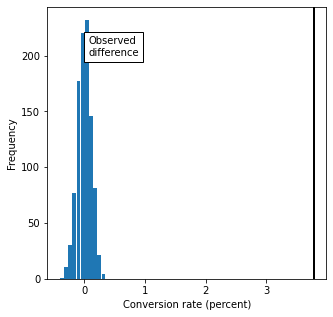

In [57]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_conv_rate, color="black", lw=2)
ax.text(0.06, 200, "Observed\ndifference", bbox={"facecolor": "white"})
ax.set_xlabel("Conversion rate (percent)")
ax.set_ylabel("Frequency")

In [61]:
# P-value: proportion of times the permutation test produced a differnce equal to or greater than observed difference.

perm_est_p = np.mean([diff > obs_conv_rate for diff in perm_diffs])

print(f"The estimated p-value from the permutation test is: {perm_est_p:.4f}")

#The mean is essentially the proportion since we can take the fact that diff > obs_conv_rate will true and false and will be interpreted as 1 and 0 respectively.

The estimated p-value from the permutation test is: 0.0000


The p-value is very small and we may conclude that the the observed difference, or more extreme than that, is not within the range of what random chance may result.

Since conversion and non-conversion is binomial, we can approximate the p-value:

In [34]:
from scipy.stats import chi2_contingency

survivors = np.array([[int(ctrl_group["Clicks"][0]),int(ctrl_group["Reach"][0]-ctrl_group["Clicks"][0])], [int(test_group["Clicks"][0]), int(test_group["Reach"][0]-test_group["Clicks"][0])]])
survivors

array([[ 7016, 49914],
       [ 3038, 32782]])

In [35]:
chi2, p_value, dof, _ = chi2_contingency(survivors)
print(f"{p_value/2:.4f}")

0.0000


The quick normal approximation using chi-squared contingency method confirm the permutation estimate of the p-value above.

### __t-Tests__

There are many types of significance tests depending on whether the data is of count data or measured data, how many samples, and what's being measured. A very common test is the *t-test*, developped in the 20s when shuffling data thousands of times was not feasable. 

__*Test statistic*__ <br>
A metric for the difference or effect of interest.

__*t-statistic*__ <br>
A standardized version of common test statistics such as means.

__*t-distribution*__ <br>
A reference distribution (this case, derived from null hypothesis), to which the observed t-statistic can be compared.

You can use the `scipy.stats.ttest_ind()` method in Python

### __Multiple Testing__

__*False discovery rate*__ <br>
Across multiple tests, the rate of making a Type 1 error.

__*Alpha inflation*__ <br>
The multiple testing phenomenon, in which *alpha*, the probability of making a Type 1 error, increases as you conduct more tests.

__*Adjustment of p-values*__ <br>
Accounting for doing multiple tests on the same data.

__*Overfitting*__ <br>
Fitting the noise.

In supervised learning tasks, a holdout set where models are assessed on data that the model has not seen before  mitigates this risk. In statistical and machine learning tasks not involving a labeled holdout set, the risk of reaching conclusions based on statistical noice persists.

### __Degrees of Freedom__

The concept is applied to statistics calculated from sample data, and refers to the number of values free to vary. Example: If you know the mean for a sample of 10 values, there are 9 degrees of freedom (once you know 9 of the sample values, the 10th can be calculated and is not free to vary).

__*n or sample size*__ <br>
The number of observations (also called *rows* or *records*) in the data.

__*d.f*__ <br>
Degrees of freedom.

When you use a sample to estimate the variance for a population, you will end up with an estimate that is slightly biased downward if you use $n$.

Not too important for data science (in the context of significance testing). The data size is usually large enough that it rarely makes a difference for a data scientist whether the denominator has $n$ or $n-1$. As $n$ gets large, the bias that would come from using $n$ in the denominator disappears.

One context where this becomes relevant in data science is when using factored variables in regression. Some regression algorithms choke if exactly redundant predictor variables are present. Consider the variable `day of week`. Even though there are seven days in a week, there are only 6 DOF in specifying day of week. Once you know the day of week is not Monday through Saturday, it must be Sunday. Including Sunday would cause the regression to fail, due to a `multicollinearity` error.

### __ANOVA__

Consider there is a comparison between multiple groups with numerical data. The statistical procedure that tests for a statistically significant difference among the groups is called *analysis of variance* (*ANOVA*).

__*Pairwise comparison*__ <br>
A hypothesis test (e.g of means) between two groups among multiple groups.

__*Omnibus test*__ <br>
A single hypothesis test of the overall variance among multiple group means.

__*Decomposition of variance*__ <br>
Separation of components contributing to an individual value (eg. from the overall average, from a treatment mean, and from residual error).

__*F-statistic*__ <br>
A standardized statistic that measures the extent to which differences among group means exceed what might be expected in a chance model.

__*SS*__ <br>
Sum of squares - referring to deviations from some average value.

ANOVA resampling procedure is as follows:
<ol>
<li>Combine all the data together in a single box.</li>
<li>Shuffle and draw out four resamples of five (or however many the test was run) values each.</li>
<li>Record the mean of each of the four groups.</li>
<li>Record the variance among the four group means.</li>
<li>Repeat steps 2 - 4 many (say 1,000) times</li>
</ol>

The proportion of times the resampled variance exceed the observed variance is the p-value

In [89]:
# Consider testing 4 golf ball designs that were shot from a machine to test the distances 10 times:
distances = pd.read_csv("Golfball.csv")
distances.head()

,Design,Distance
0,Design1,206.32
1,Design1,207.94
2,Design1,206.19
3,Design1,204.45
4,Design1,209.65


<AxesSubplot:>

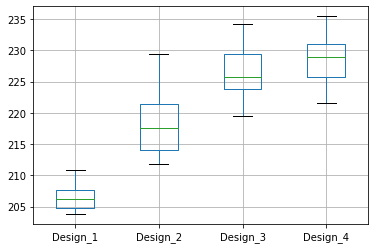

In [64]:
# Boxplot shows considerable differences among them
distances.boxplot()

In [88]:
observed_means = distances.groupby("Design").mean().values.ravel()
observed_variance = distances.groupby("Design").mean().var()[0]
print(f"Observed means: {observed_means}")
print(f"Variance: {observed_variance:.2f}")

Observed means: [206.614 218.516 226.588 228.622]
Variance: 99.70


In [101]:
def perm_test(data):
    data = data.copy()
    # Shuffle the data
    data["Distance"] = np.random.permutation(data["Distance"].values)
    return data.groupby("Design").mean().var()[0]  # Draw out 4 resamples and record the mean variance

# Resample and record mean variance many times
perm_variance = [perm_test(distances) for _ in range(1000)]

In [106]:
# Taking advantage of var > observed_variance yielding as True and False that will be interpreted as 1s and 0s respectively. The mean is then the proportion.
p_value = np.mean([var > observed_variance for var in perm_variance])
print(f"Pr(Prob): {p_value:.4f}")

Pr(Prob): 0.0000


Just like the t-test can be used instead of permutation test for comparing the mean of two groups, there is a statistical test for ANOVA based on the *F-statistic*. The *F-statistic* is based on the ratio of the variance across group means to the variance due to residual error. The higher this ratio, the more statistically significant the result.  

In [107]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.ols('Distance ~ Design', data= distances).fit()

aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Design,3.0,173.3476,57.782533,0.595276,0.622191
Residual,36.0,3494.4666,97.068517,NaN,NaN


### __Chi-Square Test__

Web testing often goes beyond A/B testing and tests multiple treatments at once.
The chi-square test is used with count data to test how well it fits some expected distribution.
Common to use $row \times column$ contingency tables.

__*Chi-square statistic*__ <br>
A measure of the extent to which some observed data departs from expectation.

__*Expectation or expected*__ <br>
How we would expect the data to turn out under some assumption, typically the null hypothesis.

__Fisher's Exact Test__

For cases when the count data is very few.
No straight forward implementation of Fisher's exact test in Python.

__Relevance for Data Science__

The goal of chi-square test, or Fisher's exact test is to know whether an effect is for real or might be the product of chance. It is not too important in data science. In most data science experiments, the goal is not simply to establis statistical significance but rather to arive at the best treatment. For this purpose, multi-armed bandits offer a more complete solution.

Chi-square tests, or similar resampling simulations, are used in data science applications more as a filter to determine whether an effect or a feature is worthy of further consideration than as a formal test of significance.

### __Multi-Arm Bandit Algorithm__

Multi-arm bandits is an approach to testing, especially web testing, that allows explicit optimization and more rapid decision making than the traditional statistical approach to designing experiments.

__*Multi-arm bandit*__ <br>
An imaginary slot machine with multiple arms for the customer to choose from, each with different payoffs, here taken to be an analogy for a multitreatment experiment.

__*Arm*__ <br>
A treatment in an experiment (eg. new headline in a web)

__*Win*__ <br>
The experimental analog of a win at the slot machine (eg. customer clicks on link)

Bandit algorithms can efficiently handle 3+ treatments and move toward optimal selection of the "best." A simple algorithm (epsilon greedy algorithm):
<ol>
<li>Generate a uniformly distributed random number between 0 and 1.</li>
<li>If the number lies between 0 and epsilon (epsilon is number between 0 and 1), flip a fair coin:</li>
    a. If the coin is heads, show offer A.<br>
    b. If the coin is tailsm show offer B.
<li>If the number is greater / equal to epsilon, show whichever offer has had the highes response rate to date. </li>
</ol>

### __Power and Sample Size__

How long should you run a web test? There is no general guidance. Depends on the frequency with which the desired goal is attained.

__*Effect size*__ <br>
The minimum size of the effect that you hope to be able to detect in a statistical test, such as "a 20% improvement in click rates."

__*Power*__ <br>
The probability of detecting a given effect size with a given sample size.

__*Significance level*__ <br>
The statistical significance level at which the test will be conducted.